In [1]:
import glob
import os
from dataclasses import dataclass, field

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pytz
from astral import LocationInfo
from astral.sun import sun
from scipy.stats import norm, cauchy
from pandas.tseries.offsets import MonthBegin, MonthEnd

import strat_defs # custom functions
import prep_data

In [3]:
stocks_df, wiki_pageviews, ffr_raw, weather, gt_adjusted = prep_data.load_data()

# Set up prepd_data data frame
prepd_data = prep_data.prep_data(
    stocks_df,
    wiki_pageviews,
    ffr_raw,
    weather,
    gt_adjusted,
    config=prep_data.IndicatorConfig(ticker="SPY"),
    drop_tickers=True
)

In [22]:
prepd_data.loc[~prepd_data['index_Trump'].isna(),['Date','Adj Close_SPY','index_Trump','index_unemployment benefits']]

,Date,Adj Close_SPY,index_Trump,index_unemployment benefits
2753,2004-01-02,74.680298,0.3800,NaN
2754,2004-01-05,75.492691,0.2080,NaN
2755,2004-01-06,75.566544,0.1120,NaN
2756,2004-01-07,75.821663,0.3040,NaN
2757,2004-01-08,76.123810,0.2240,NaN
...,...,...,...,...
8100,2025-04-03,536.700012,7.9872,NaN
8101,2025-04-04,505.279999,8.3200,NaN
8102,2025-04-07,504.380005,7.5168,NaN
8103,2025-04-08,496.480011,6.6816,NaN


In [57]:
gt_monthly_files = glob.glob('gt_monthly_*.csv')
gt_monthly_latest = max(gt_monthly_files, key=os.path.getctime)
gt_monthly_raw = pd.read_csv(gt_monthly_latest, parse_dates=['start_date','end_date'])

gt_weekly_files = glob.glob('gt_weekly_*.csv')
gt_weekly_latest = max(gt_weekly_files, key=os.path.getctime)
gt_weekly_raw = pd.read_csv(gt_weekly_latest, parse_dates=['start_date','end_date'])

gt_daily_files = glob.glob('gt_daily_*.csv')
gt_daily_latest = max(gt_daily_files, key=os.path.getctime)
gt_daily_raw = pd.read_csv(gt_daily_latest, parse_dates=['date'])

gt_adjusted_files = glob.glob('gt_adjusted_*.csv')
gt_adjusted_latest = max(gt_adjusted_files, key=os.path.getctime)
gt_adjusted_raw = pd.read_csv(gt_adjusted_latest, parse_dates=['date'])

In [69]:
gt_weekly_raw.loc[gt_weekly_raw['search_term']=="unemployment benefits"]

,start_date,index,isPartial,end_date,search_term,pytrends_params


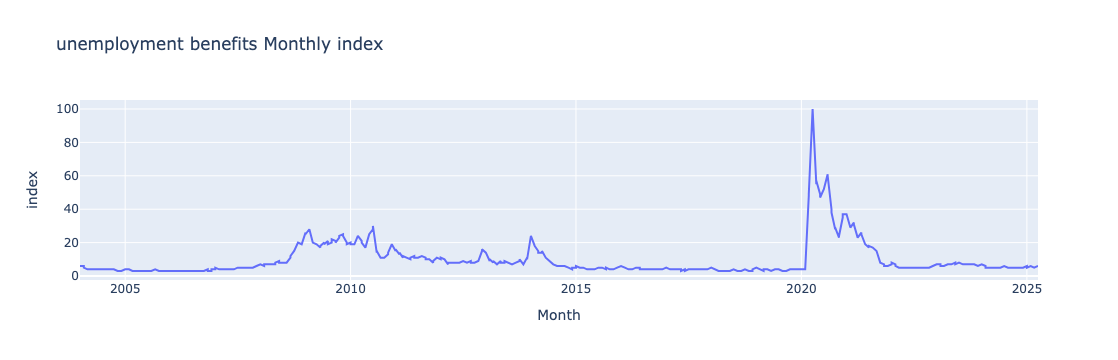

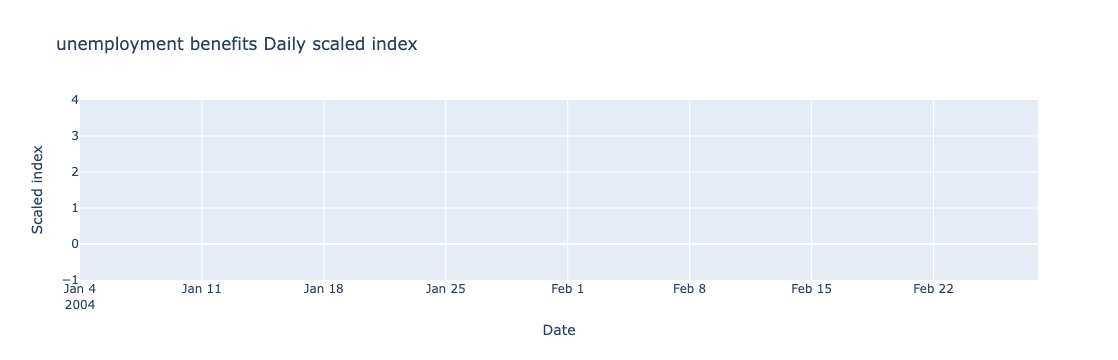

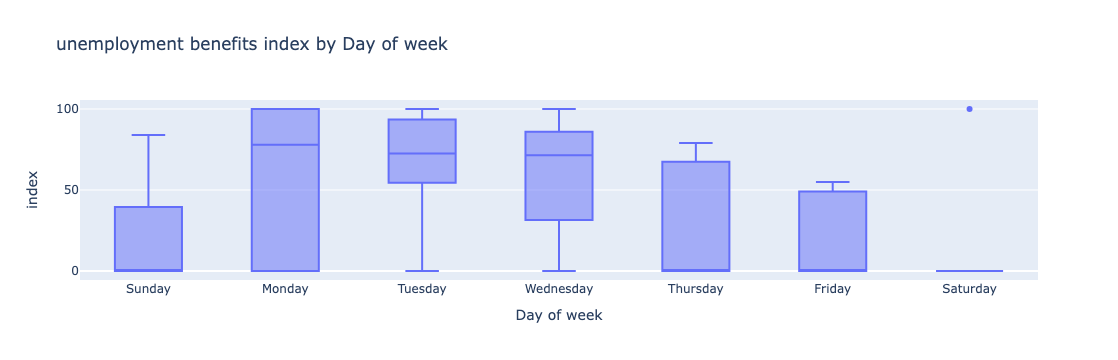

In [43]:
selected_kw = "unemployment benefits"

for_monthly = gt_monthly_raw.loc[gt_monthly_raw['search_term']==selected_kw].sort_values(by='start_date')
for_daily = gt_adjusted_raw.loc[gt_adjusted_raw['search_term']==selected_kw].sort_values(by='date')
for_daily_bp = gt_daily_raw.loc[gt_daily_raw['search_term']==selected_kw].sort_values(by='date')
for_daily_bp['day_of_week'] = for_daily_bp['date'].dt.day_name()

fig1 = px.line(for_monthly, x="start_date", y="index", labels={'start_date':'Month'},title=f'{selected_kw} Monthly index')
fig2 = px.line(for_daily, x="date", y="index",labels={'date':'Date','index':'Scaled index'},title=f'{selected_kw} Daily scaled index')
fig3 = px.box(for_daily_bp, x="day_of_week", y="index",labels={'day_of_week':'Day of week'},title=f'{selected_kw} index by Day of week')
fig3.update_xaxes(categoryorder='array', categoryarray=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])
fig1.show()
fig2.show()
fig3.show()

In [ ]:
vol_cols = [col for col in prepd_data.columns if 'Volume_' in col]

column_sums = prepd_data[vol_cols].sum().sort_values(ascending=False)

fig = px.bar(x=column_sums.index.str.replace('Volume_', ''), y=column_sums.values,
             labels={'x': 'Ticker', 'y': 'Total Volume'}, title="Total Volume by Ticker")

fig.show()

In [ ]:
column_sums.tail(10)

In [ ]:
data = prepd_data['Daily_Return'].dropna()

# Compute histogram using numpy to get exact bin edges and bin width
hist_values, bin_edges = np.histogram(data, bins=300, density=False)
bin_width = bin_edges[1] - bin_edges[0]

# x values covering the histogram's range using the same bin edges
x = np.linspace(bin_edges[0], bin_edges[-1], 100)

# Create a histogram in Plotly using explicit binning to match np.histogram
hist = go.Histogram(x=data, xbins=dict(start=bin_edges[0], end=bin_edges[-1], size=bin_width), name="Histogram")

# Fit distributions and create PDFs
mu, std = norm.fit(data)
loc, scale = cauchy.fit(data)

pdf_norm = norm.pdf(x, mu, std) * len(data) * bin_width
pdf_cauchy = cauchy.pdf(x, loc, scale) * len(data) * bin_width

# Create curves
curve_norm = go.Scatter(x=x, y=pdf_norm, mode='lines', name="Fitted Normal")
curve_cauchy = go.Scatter(x=x, y=pdf_cauchy, mode='lines', name="Fitted Cauchy")

fig = go.Figure([hist, curve_norm, curve_cauchy])
fig.update_layout(title=f"{indicator_config.ticker} Daily Return Histogram with Fitted Normal and Cauchy Distributions",
                  xaxis_title="Value", yaxis_title="Frequency")
fig.show()

In [ ]:
fig = px.scatter(x=prepd_data['Volume'+"_"+indicator_config.ticker],              
                 y=prepd_data['Daily_Return'])

fig.update_layout(title=f"{indicator_config.ticker} Daily Return vs Volume",
                  xaxis_title="Volume", yaxis_title="Daily Return")

fig.show()